# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether leaves are healthy or infected with powdery mildew.


## Inputs

* inputs/cherry_dataset/cherry-leaves/test
* inputs/cherry_dataset/cherry-leaves/train
* inputs/cherry_dataset/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions

Credits: The code has been modified according Code Institute walkthrough project.


---

---

# Import regular packages

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# ML packages from TF
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

---

# Set Working Directory

In [4]:
cwd= os.getcwd()

In [5]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [6]:

work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

## Set input directories

Set train, validation and test paths

In [7]:
my_data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [9]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [10]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




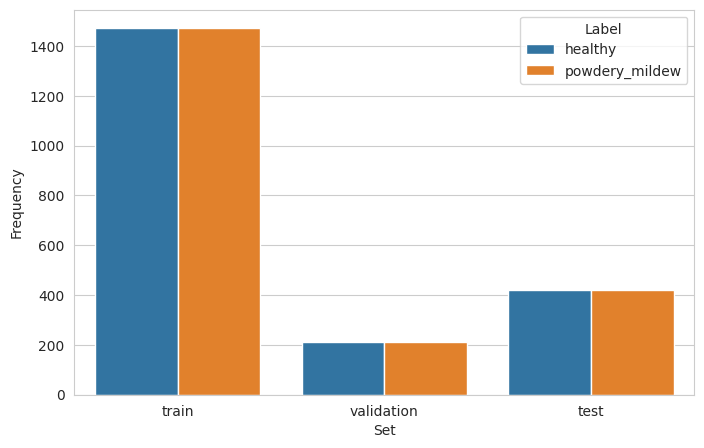

In [11]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

---

### ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=10,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [14]:
batch_size = 15  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(15, 50, 50, 3)


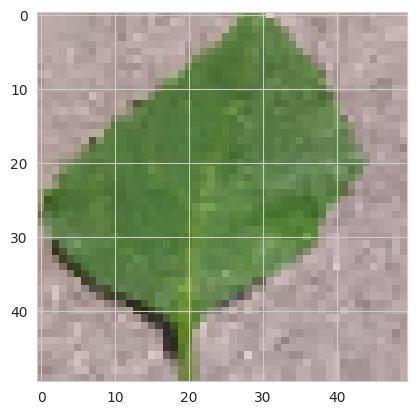

(15, 50, 50, 3)


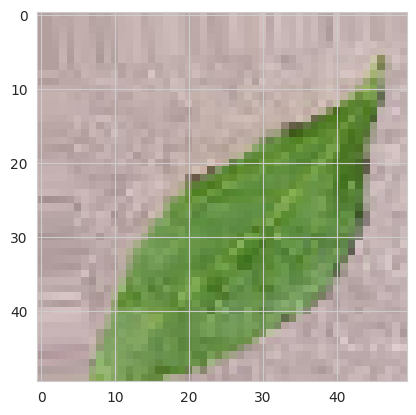

(15, 50, 50, 3)


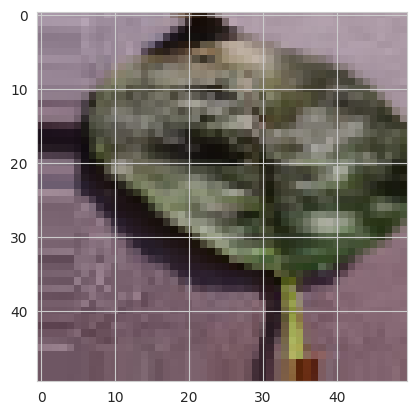

(15, 50, 50, 3)


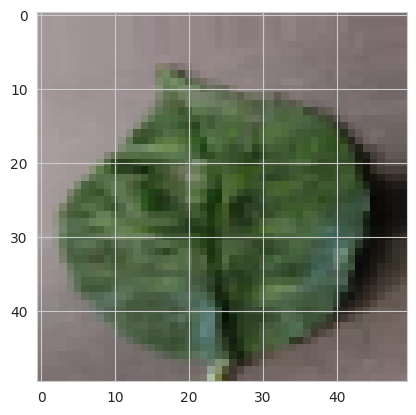

(15, 50, 50, 3)


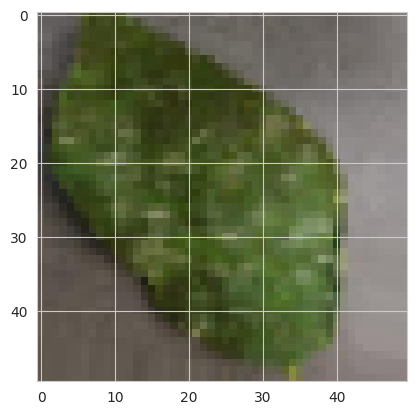

In [17]:
for _ in range(5):
    img, label = train_set.next()
    print(img.shape)  # (batch_size,h,v,rgb)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(15, 45, 45, 3)


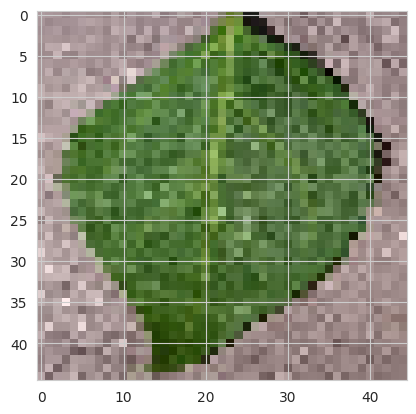

(15, 45, 45, 3)


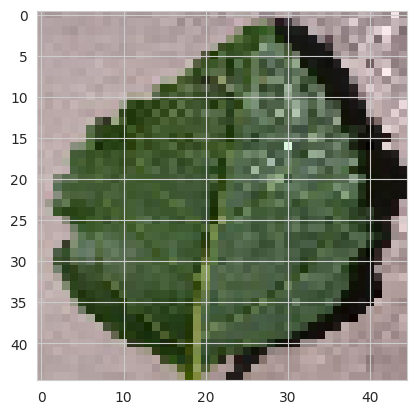

(15, 45, 45, 3)


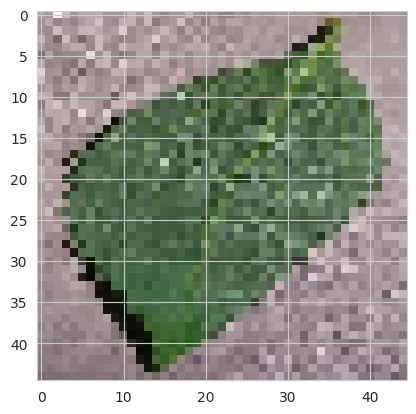

In [89]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()


(15, 45, 45, 3)


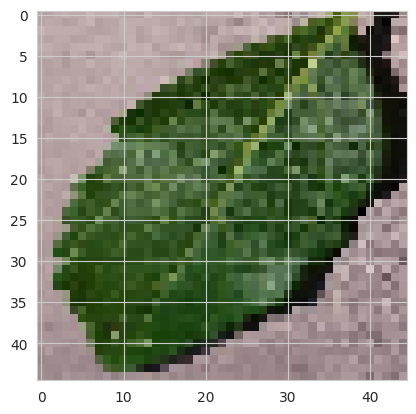

(15, 45, 45, 3)


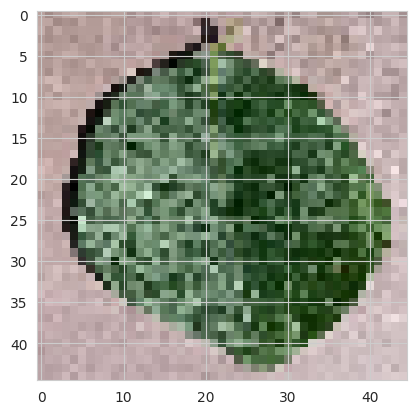

(15, 45, 45, 3)


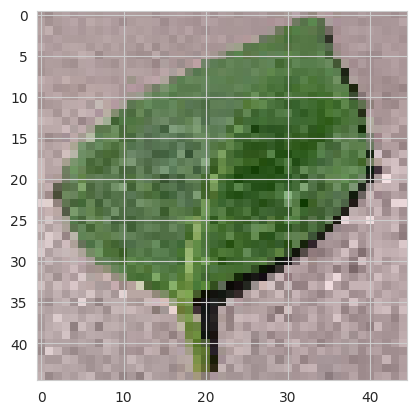

In [90]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [91]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [93]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [94]:
create_tf_model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 43, 43, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 9, 9, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 3, 3, 64)         

* ### Early Stopping -define a call back function to monitor accuracy

In [95]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

## Fit model for model training

In [96]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[callbacks],
          verbose=1
          )


Epoch 1/20


196/196 [==============================] - 11s 49ms/step - loss: 0.3696 - accuracy: 0.8231 - val_loss: 0.1491 - val_accuracy: 0.9238
Epoch 2/20
196/196 [==============================] - 7s 35ms/step - loss: 0.1786 - accuracy: 0.9344 - val_loss: 0.0556 - val_accuracy: 0.9905
Epoch 3/20
196/196 [==============================] - 5s 27ms/step - loss: 0.1065 - accuracy: 0.9669 - val_loss: 0.0204 - val_accuracy: 0.9929
Epoch 4/20
196/196 [==============================] - 6s 30ms/step - loss: 0.0645 - accuracy: 0.9802 - val_loss: 0.0386 - val_accuracy: 0.9905
Epoch 5/20
196/196 [==============================] - 10s 50ms/step - loss: 0.0550 - accuracy: 0.9816 - val_loss: 0.0352 - val_accuracy: 0.9905
Epoch 6/20
196/196 [==============================] - 7s 38ms/step - loss: 0.0474 - accuracy: 0.9860 - val_loss: 0.0193 - val_accuracy: 0.9952
Epoch 7/20
196/196 [==============================] - 5s 25ms/step - loss: 0.0410 - accuracy: 0.9860 - val_loss: 0.0264 - val_accuracy: 0.9881
Epoch 8/

## Save model

In [97]:
model.save('outputs/v1/cherry_leaves_model.h5')

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

# Model Performace

---

## Model learning curve

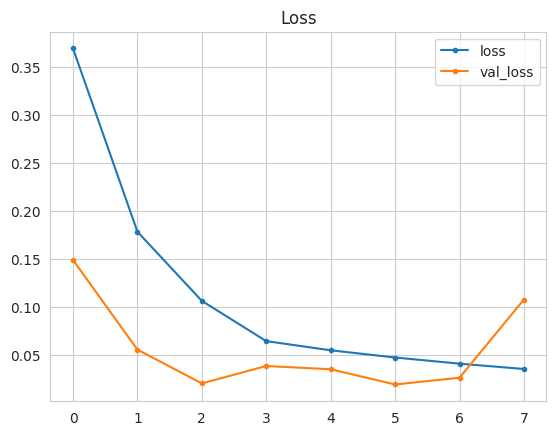

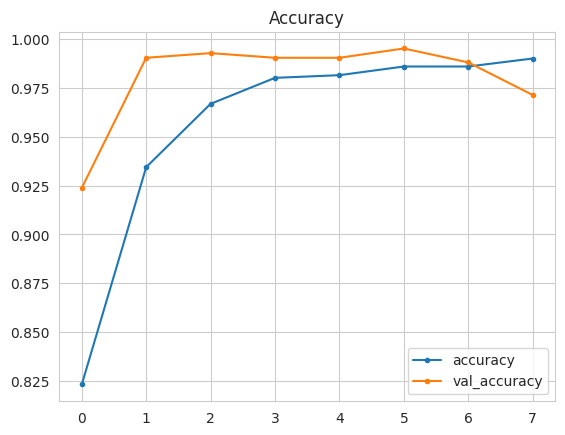

In [98]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [99]:
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_model.h5')

Evaluate model on test set

In [100]:
evaluation = model.evaluate(test_set)


40/57 [====================>.........] - ETA: 0s - loss: 0.0727 - accuracy: 0.9850

57/57 [==============================] - 1s 14ms/step - loss: 0.0962 - accuracy: 0.9799


### Save evaluation pickle

In [101]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (45, 45), Image mode: RGB


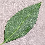

In [102]:
from tensorflow.keras.preprocessing import image

pointer = 99 #pointing to a random image from the test data
label = labels[0]  # select healthy or mildew powdery 

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [103]:
predicted_image = image.img_to_array(pil_image)
predicted_image = np.expand_dims(predicted_image, axis=0)/255
print(predicted_image.shape)
predicted_image

(1, 45, 45, 3)


array([[[[0.89411765, 0.8392157 , 0.8392157 ],
         [0.84313726, 0.7882353 , 0.7882353 ],
         [0.81960785, 0.7647059 , 0.7647059 ],
         ...,
         [0.74509805, 0.6901961 , 0.6901961 ],
         [0.77254903, 0.7176471 , 0.7176471 ],
         [0.8392157 , 0.78431374, 0.78039217]],

        [[0.8392157 , 0.78431374, 0.78431374],
         [0.8352941 , 0.78039217, 0.78039217],
         [0.8745098 , 0.81960785, 0.81960785],
         ...,
         [0.87058824, 0.8156863 , 0.8039216 ],
         [0.7764706 , 0.72156864, 0.7176471 ],
         [0.85490197, 0.79607844, 0.8156863 ]],

        [[0.8156863 , 0.7607843 , 0.7607843 ],
         [0.80784315, 0.7529412 , 0.7529412 ],
         [0.8784314 , 0.8235294 , 0.8235294 ],
         ...,
         [0.79607844, 0.74509805, 0.7137255 ],
         [0.8       , 0.74509805, 0.7411765 ],
         [0.84705883, 0.7882353 , 0.8156863 ]],

        ...,

        [[0.84313726, 0.7921569 , 0.76862746],
         [0.9372549 , 0.8392157 , 0.85490197]

Predict class probabilities

In [106]:
pred_proba = model.predict(predicted_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 [==============================] - 0s 66ms/step
0.999999999783534
healthy


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [107]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
venv
.DS_Store
inputs/cherry_dataset/cherry-leaves/test
inputs/cherry_dataset/cherry-leaves/train
jupyter_notebooks
.devcontainer
*.ipynb

* Git status

In [108]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    inputs/cherry_dataset/cherry-leaves/validation/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092.JPG
	deleted:    inputs/cherry_dataset/cherry-leaves/validation/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277_flipTB.JPG
	deleted:    inputs/cherry_dataset/cherry-leaves/validation/healthy/02a7466b-4847-4a18-bbd9-f0278e7b8d20___JR_HL 9582.JPG
	deleted:    inputs/cherry_dataset/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600_180deg.JPG
	deleted:    inputs/cherry_dataset/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600_flipTB.JPG
	deleted:    inputs/cherry_dataset/cherry-leaves/validation/healthy/050b598c-9105-4838-8996-101568d6941e___JR_HL 9732_180deg.JPG
	deleted:  

* Git add

In [115]:
!git add .

* Git commit

In [116]:
!git commit -am "Reduce slug"

[main 5ac6d4e] Reduce slug
 2 files changed, 14 insertions(+), 775 deletions(-)


* Git Push

In [117]:
!git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 16 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 685 bytes | 685.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0), pack-reused 0


remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/lucijahajdu/mildew-detection-in-cherry-leaves.git
   b35495a..5ac6d4e  main -> main


---